Lets create a monte carlo pricing of an option on 2 underlying correlated stocks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Parameters
S0 = 100.0  # underlyer of stock S at T_0
B0 = 100.0  # underlyer of stock B at T_0
B_vol = 0.2 # B's vol
S_vol = 0.3 # S's vol
K = 105.    # call option strike
T = 1.0     # expiry
r = 0.05    # risk-free rate
M = 50      # number of steps
dt = T/M    # period of each step
I = 250000  # number of trials

In [6]:
np.random.seed(20000)

# 25 rhos between -1 and +1
rhos = np.linspace(-0.99, 0.99, 25)
prices = []

for rho in rhos:
    
    # calculate cholesky matrix from correlation matrix (better be positive semi-definite or this won't work)
    # this is used to transform independent random variables to correlated random variables
    corr_mat = np.zeros((2, 2))
    corr_mat[0,:] = [1.0, rho]
    corr_mat[1,:] = [rho, 1.0]
    cho_mat = np.linalg.cholesky(corr_mat)

    # draw random variables from a standard normal distribution
    # 2 stocks x M+1 time-steps x I paths
    ran_num = np.random.standard_normal((2, M+1, I))

    # simulate underlyer paths
    B = np.zeros_like(ran_num[0]) # M+1 steps x I paths
    S = np.zeros_like(B)          # M+1 steps x I paths
    B[0] = B0
    S[0] = S0
    for t in range(1, M + 1):
        # generate correlated random variables for current step t (across both stock and each path)
        ran = np.dot(cho_mat, ran_num[:,t,:])
        # evolve path using geometric brownian motion
        B[t] = B[t-1] * np.exp((r-0.5*B_vol**2)*dt + B_vol * np.sqrt(dt) * ran[0])    
        S[t] = S[t-1] * np.exp((r-0.5*S_vol**2)*dt + S_vol * np.sqrt(dt) * ran[1])
    
    # payoff at expiry is a european call option but using max between B and S
    payoff = np.maximum(np.maximum(B[-1],S[-1])-K, 0)
    prices.append(np.exp(-r*T)*np.sum(payoff)/I)

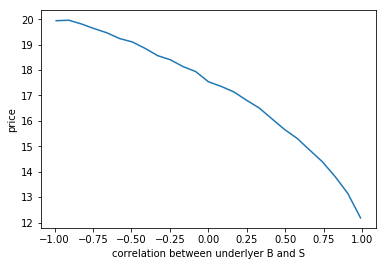

In [8]:
plt.plot(rhos, prices)
plt.xlabel('correlation between underlyer B and S')
plt.ylabel('price')